In [8]:
# Load configuration
%run config.ipynb

In [9]:
import os
import re
import pandas as pd

time_pattern = r"([0-9.]+)\s([a-z ]+)"

def convert(value):
    try:
        return float(value)
    except ValueError:
        return value

# Extract measurements from output of bash `time` command (on OSX)
def extract_measurements(fixed, fpath):
    with open(fpath, 'r') as file:
        content = file.readlines()
    measurements = fixed.copy()
    for line in content:
        matches = re.findall(time_pattern, line)
        for match in matches:
            value, key = match
            measurements[key.strip()] = convert(value)
    return measurements

# Parse (tpcds) ascii table columns (and line offset for first data row)
def ascii_table_columns(lines):
    for i, line in enumerate(lines):
        if re.match(r'\+-+\+-+', line):
            return [header.strip() for header in lines[i + 1].split('|')[1:-1]], i+3

# Parse (tpcds) ascii table rows
def ascii_table_data(fixed, lines):
    rows = []
    for line in lines:
        if re.match(r'\+-+\+-+', line):
            break
        row = [convert(cell.strip()) for cell in line.split('|')[1:-1]]
        rows.append(fixed + row)
    return rows

def load_dataframes():
    time_measurements = []
    tpcds_rows = []
    tpcds_headers, tpcds_offset = None, None
    for root, dirs, files in os.walk(BENCHMARKS_DIR):
        data_size, runner, config_id, run_id = root.rsplit('/', 4)[-4:]
        for fname in files:
            fpath = os.path.join(root, fname)
            if (runner.startswith('_') | config_id.startswith('_') | config_id.startswith('sdf_sync')):
                continue
            if not (config_id.endswith('-cops-noBiasedLocking')):
                continue
            if (fname == "timings.txt") & os.path.isfile(fpath):
                time_measurements.append(extract_measurements({'runner': runner, 'config': config_id, 'run': run_id, 'data_size': data_size}, fpath))
            if (fname == "queries.txt") & os.path.isfile(fpath):
                with open(fpath, 'r') as file:
                    lines = file.readlines()
                if not tpcds_headers:
                    tpcds_headers, tpcds_offset = ascii_table_columns(lines)
                tpcds_rows = tpcds_rows + ascii_table_data([runner, config_id, run_id],lines[tpcds_offset:])
    return pd.DataFrame(time_measurements), pd.DataFrame(tpcds_rows, columns=['runner', 'config', 'run'] + tpcds_headers)

descriptions = {
    'real': 'Elapsed Time (sec)',
    'user': 'User Time (sec)',
    'sys': 'System Time (sec)',
    'maximum resident set size': 'Maximum Resident Set Size',
    'page reclaims': 'Memory pages reclaimed',
    'voluntary context switches': 'Voluntary Context Switches',
    'involuntary context switches': 'Involuntary Context Switches'
}

time_df, queries_df = load_dataframes()

time_df = time_df.rename(columns=descriptions)
time_df['Maximum Resident Set Size (GB)'] = time_df['Maximum Resident Set Size'] / 1024 / 1024 / 1024

In [10]:
import matplotlib.pyplot as plt

boxplot_style = {'width': 1, 'fliersize': 0, 'boxprops': {'edgecolor': 'white', 'alpha': 0.95}}
text_style = {'ha': 'center', 'va': 'center', 'size': 'small', 'fontweight': 'light'}
grid_style = {'hspace': 0.4, 'wspace': 0.4}

def add_legend(fig, values, title, colors):
    legend_patches = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(values))]
    fig.legend(legend_patches, values, title=title, bbox_to_anchor=(1, 1), loc='upper left', frameon=True)

def benchmark_col(df):
    return df['runner'] +' [' + df['config'] +']'# + time_df['data_size']

def rows(plots, cols = 3):
    return (len(plots) // cols) + (len(plots) % cols > 0)

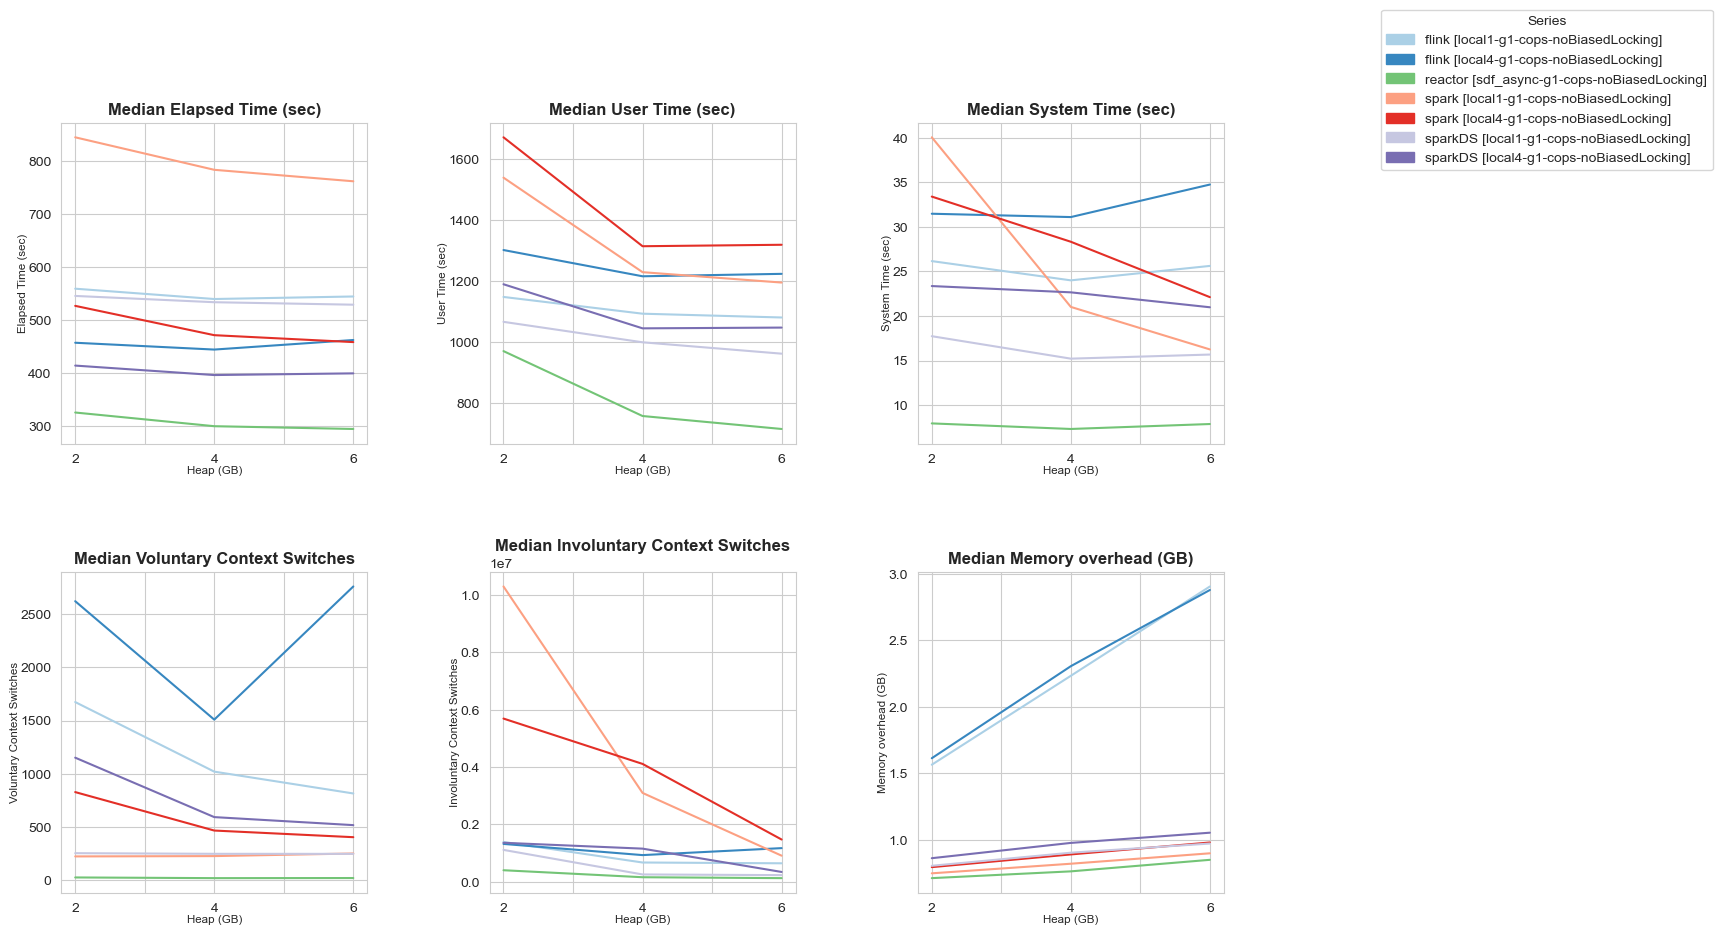

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Blues", 2) + sns.color_palette("Greens", 1) + sns.color_palette("Reds", 2) + sns.color_palette("Purples", 2)  # sns.color_palette("Greys", 2) + sns.color_palette("Oranges", 2) + 
sns.set_palette(colors)
sns.set_style("whitegrid")

def plot_heap_series(df, plots):
    df['benchmark'] = benchmark_col(df)
    df['series'] = df['benchmark'].str.replace('-\dg', '', regex=True)
    df['heap'] = df['config'].str.extract(r'-(\d)g-')

    df['Memory overhead (GB)'] = df['Maximum Resident Set Size (GB)'] - pd.to_numeric(df['heap'])
    
    df = df.sort_values(by=['benchmark'])
    
    fig, axes = plt.subplots(nrows=rows(plots), ncols=3, figsize=(15, 5*(rows(plots))), gridspec_kw=grid_style)
    
    for i, col in enumerate(plots):
        ax = axes[i // 3][i % 3]
        
        medians_df = df.groupby(['series', 'heap'])[col].median().reset_index()
        for name in medians_df['series'].unique():
            medians_df[medians_df['series'] == name].plot('heap', col, ax=ax, label=name, legend=False)

        ax.set_title('Median ' + col, weight='bold')
        ax.set_ylabel(col, **text_style)
        ax.set_xlabel('Heap (GB)', **text_style)

    add_legend(fig, df['series'].unique(), 'Series', colors)

    plt.show()

plot_heap_series(time_df,[
    'Elapsed Time (sec)', 'User Time (sec)', 'System Time (sec)', 
    'Voluntary Context Switches', 'Involuntary Context Switches', 'Memory overhead (GB)'])

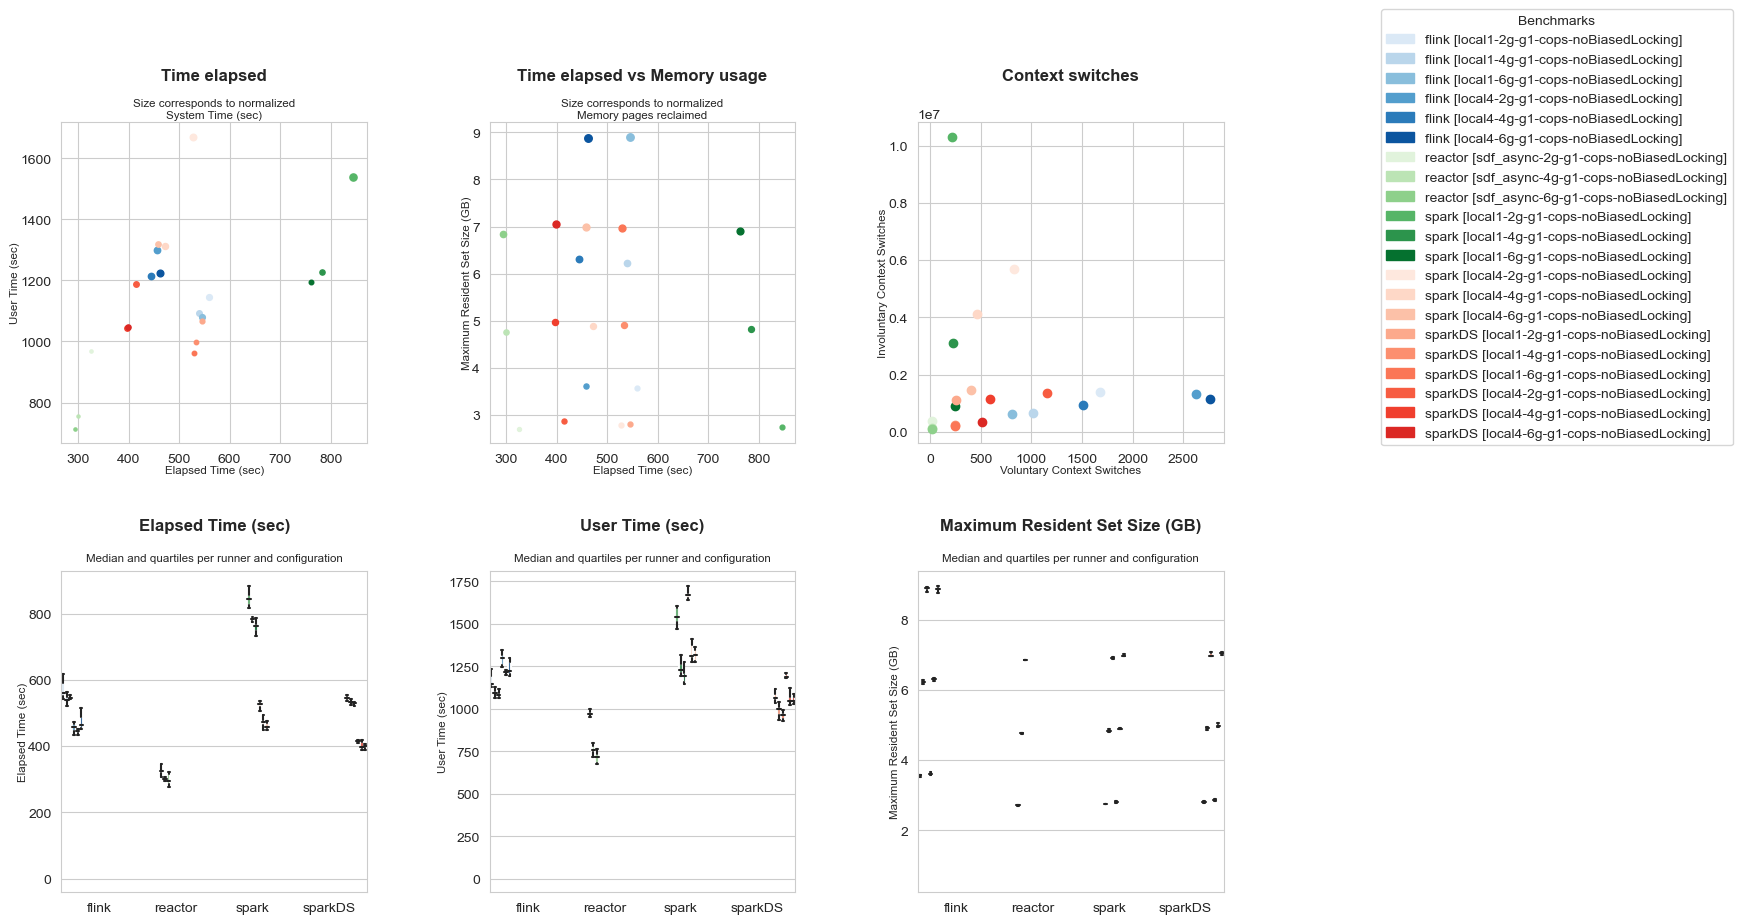

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Blues", 6) + sns.color_palette("Greens", 6) + sns.color_palette("Reds", 12) + sns.color_palette("Purples", 12)  # sns.color_palette("Greys", 2) + sns.color_palette("Oranges", 2) + 
sns.set_palette(colors)
sns.set_style("whitegrid")

def plot_heap_series(df, scatterplots, boxplots):
    df['benchmark'] = benchmark_col(df)
    df = df.sort_values(by=['benchmark'])
    
    s_rows = rows(scatterplots)
    b_rows = rows(boxplots)
    
    fig, axes = plt.subplots(nrows=s_rows + b_rows, ncols=3, figsize=(15, 5*(s_rows + b_rows)), gridspec_kw=grid_style)
    
    for i, (title, (x_col, y_col, z_col)) in enumerate(scatterplots.items()):
        ax = axes[i // 3][i % 3]
        fac = df[z_col].max()/30 if z_col else None
        for name, group in df.groupby('benchmark').median(numeric_only=True).iterrows():
            ax.scatter(group[x_col], group[y_col], s=group[z_col] / fac if z_col else None, label=name)
        ax.set_title(title, pad=30, weight='bold')
        ax.set_xlabel(x_col, **text_style)
        ax.set_ylabel(y_col, **text_style)
        if z_col:
            ax.text(0.5, 1.04, f"Size corresponds to normalized\n{z_col}", transform=ax.transAxes, **text_style)

    for i, col in enumerate(boxplots):
        ax = axes[s_rows + i // 3][i % 3]
        sns.boxplot(x="runner", y=col, hue='benchmark', data=df, ax=ax, **boxplot_style)
        ax.set_title(col, pad=30, weight='bold')
        ax.text(0.5, 1.04, f"Median and quartiles per runner and configuration", transform=ax.transAxes, **text_style)
        ax.set_xlabel('')
        ax.set_ylabel(col, **text_style)
        ax.get_legend().remove()

    add_legend(fig, df['benchmark'].unique(), 'Benchmarks', colors)

    plt.show()


plot_heap_series(
    time_df.rename(columns=descriptions), 
    scatterplots = {
        'Time elapsed': ('Elapsed Time (sec)', 'User Time (sec)', 'System Time (sec)'), 
        'Time elapsed vs Memory usage': ('Elapsed Time (sec)', 'Maximum Resident Set Size (GB)', 'Memory pages reclaimed'), 
        'Context switches': ('Voluntary Context Switches', 'Involuntary Context Switches', None),
    },
    boxplots = ['Elapsed Time (sec)', 'User Time (sec)', 'Maximum Resident Set Size (GB)']
)

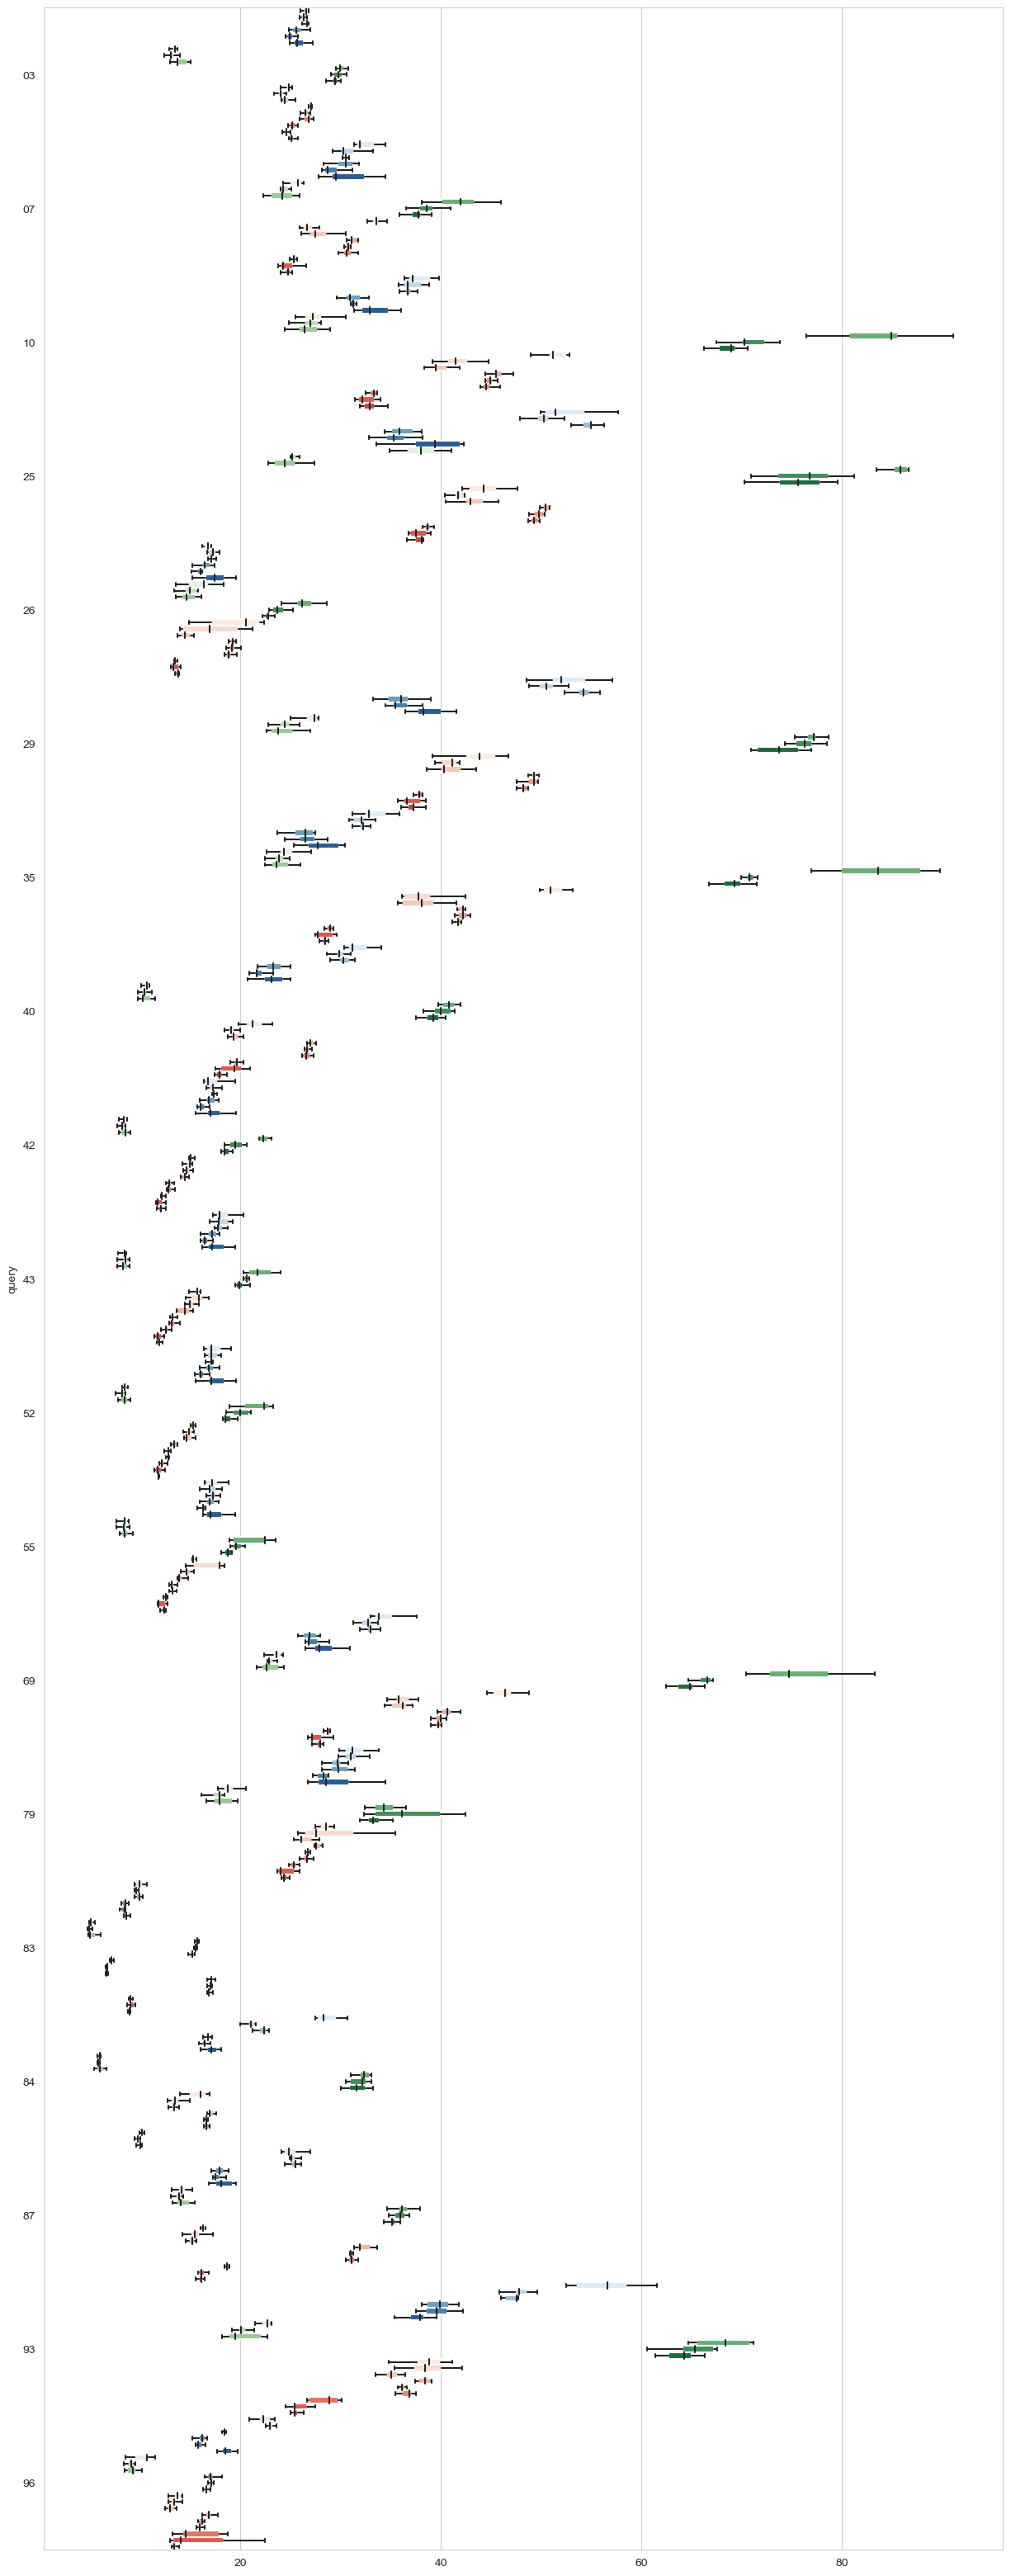

In [13]:

def plot_queries(df):
    df['benchmark'] = benchmark_col(df)
    df['query'] = df['Query Name'].str.lstrip('query').str.zfill(2)
    df = df.sort_values(by=['benchmark', 'query'])

    fig, axes = plt.subplots(ncols=1, figsize=(15, 40))

    sns.boxplot(y="query", x="Elapsed Time(sec)", hue='benchmark', data=df, ax=axes, **boxplot_style)
    axes.set_xlabel('')
    axes.get_legend().remove()

plot_queries(queries_df)